In [4]:
!pip install umap-learn

  Using cached umap-learn-0.5.3.tar.gz (88 kB)
  Preparing metadata (setup.py) ... done
  Using cached pynndescent-0.5.8.tar.gz (1.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82820 sha256=4adb25a1ecde19505e19e07e7ad6fdf092e44973f1dab9a984d044aca491304c
  Stored in directory: /home/nir/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55498 sha256=0b9bd0187fd389a20b38b7e3922395fbc407b7fe4c76458de222baf8cdcaba3e
  Stored in directory: /home/nir/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [5]:
import numpy as np
import torch
import math
import umap.umap_ as umap
import os
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from torchvision.datasets import FashionMNIST, CIFAR100
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms

2023-04-06 17:04:43.884293: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
# DATA_DIR = '/content/drive/MyDrive/AML_project/datasets/FMNIST_DATASET'
DATA_DIR = '/tmp/vae_datasets/cifar100'
BATCH_SIZE = 200
SEED = 42
LOAD_MODEL = False
NUM_MINIBATCHES = 4

In [10]:
!mkdir /tmp/vae_datasets

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('## CUDA ##')
else:
    device = torch.device('cpu')

if os.path.isdir(DATA_DIR):
    train_data = CIFAR100(root=DATA_DIR, train=True, transform=transforms.ToTensor())
    test_data = CIFAR100(root=DATA_DIR, train=False, transform=transforms.ToTensor())
else:
    os.mkdir(DATA_DIR)
    train_data = CIFAR100(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())
    test_data = CIFAR100(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=1,
                          drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=1,
                         drop_last=False)

fmnist_classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

cifar_classes = train_data.classes

data_shape = train_data.data.shape[1:]

## CUDA ##


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /tmp/vae_datasets/cifar100/cifar-100-python.tar.gz to /tmp/vae_datasets/cifar100
Files already downloaded and verified


In [12]:
for x, y in train_data:
    break

In [15]:
y

19

In [17]:
def display(images, length):
    f, axes = plt.subplots(1, length, sharex='col', sharey='row')
    plt.figure(figsize=(18, 6))
    for i, image in enumerate(images):
        image = image.data.cpu().view(data_shape)
        if len(images) > 1:
            _ = axes[i].imshow(image, cmap='gray')
        else:
            _ = axes.imshow(image, cmap='gray')
def reparametrize(mu, std, device):
    """
    Performs reparameterization trick z = mu + epsilon * std
    Where epsilon~N(0,1)
    """
    mu = mu.expand(1, *mu.size())
    std = std.expand(1, *std.size())
    eps = torch.normal(0, 1, size=std.size()).to(device)
    return mu + eps * std

class VAE(nn.Module):
    """
    Just your regular variational auto encoder (not IB)
    """
    def __init__(self, k, device):
        super(VAE, self).__init__()
        self.device = device
        self.description = 'Vanilla IB VAE as per the paper'
        self.k = k
        self.train_loss = []
        self.test_loss = []

        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.BatchNorm2d(12),                                   # added batchnorm layer
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.BatchNorm2d(24),                                   # added batchnorm layer
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.BatchNorm2d(48),                                   # added batchnorm layer
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(48*4*4, 1024)
        self.fc2 = nn.Linear(512, 48*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.BatchNorm2d(24),                                   # added batchnorm layer
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.BatchNorm2d(12),                                   # added batchnorm layer
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

        # Xavier initialization
        for _, module in self._modules.items():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                        module.bias.data.zero_()
                        continue
            for layer in module:
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                            nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
                            layer.bias.data.zero_()
        
    def forward(self, x):
        # squiwsh from shape (100,1,28,28) to (100,784)
#         x = x.view(x.size(0),-1)
        encoded_filters = self.encoder(x)
        encoded = encoded_filters.view(encoded_filters.size(0), -1)
        z_params = self.fc1(encoded)
        mu = z_params[:, :self.k]
        # softplus transformation (soft relu) and a -5 bias is added as in the paper
        std = F.softplus(z_params[:, self.k:] - 5, beta=1)
        if self.training:
            z = reparametrize(mu, std, self.device)
        else:
            z = mu.clone().unsqueeze(0)
        n = Normal(mu, std)
        log_probs = n.log_prob(z.squeeze(0))  # These may be positive as this is a PDF
        
        decodable = self.fc2(z.squeeze(0))
        decodable = decodable.view(decodable.size(0), 48, 4, 4)
        decoded = self.decoder(decodable)
        return (mu, std), log_probs, decoded
   
def vae_loss(x_hat, x, mu, std, beta):
    reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
    normalization_loss = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2)).sum()
    # KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return reconstruction_loss + beta * normalization_loss

# plt.imshow(transforms.ToPILImage()(x[100].to(torch.device('cpu'))))

def control_vae(computed_kl, previous_I, previous_beta, desired_kl = 200, K_p = 0.01, K_i = 0.0001, b_min=0, b_max=1):
    """
    Outputs beta(t) as per https://arxiv.org/pdf/2004.05988.pdf
    """   
    e_t = (desired_kl - computed_kl).to(device).detach().item()
    P_t = K_p / (1 + np.exp(e_t))
    if b_min <= previous_beta <= b_max:
        I_t = previous_I - K_i * e_t
    else:
        I_t = previous_I
    beta = P_t + I_t + b_min
    if beta > b_max:
        beta = b_max
    if beta < b_min:
        beta = b_min
    return beta, I_t


In [21]:
kld_from_base_dist_list = []
kld_from_std_normal_list = []
ratio_list = []
cycle_betas = []
control_betas = []
def loop_data(model, dataloader, beta,
              is_train, model_save_path, epochs,
              device, optimizer=None, scheduler=None, eta=0.001):
    """
    loops over the dataset, collects metrics and train 
    a model if is_train is True
    """
    if is_train:
        model.train()
    else:
        model.eval()
        epochs = 1

    global kld_from_base_dist_list
    global kld_from_std_normal_list
    global ratio_list
        
    for e in range(epochs):
        epoch_loss = 0        
        for batch_num, (images, labels) in enumerate(dataloader):
            # Compute base z distribution
            with torch.no_grad():
                x = images.to(device)
                (base_mu, base_std), base_log_probs, _ = model(x)
                
            for i in range(NUM_MINIBATCHES):
                x = images.to(device)
                y = labels.to(device)
                (mu, std), log_probs, decoded = model(x)
                x_hat = decoded.view(-1, data_shape[0]*data_shape[1]*data_shape[2])
                x = x.view(-1, data_shape[0]*data_shape[1]*data_shape[2])
                
                reconstruction_loss = F.mse_loss(x_hat, x, reduction='none')
                kld_from_std_normal = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2))                
                log_ratio = log_probs - base_log_probs
                ratio = log_ratio.exp().mean(axis=-1)  # this must be aggregated
                
#                 kld_from_base_dist = kl_divergence_gaussian(base_mu, base_std, mu, std)
                with torch.no_grad():
                    kld_from_base_dist = torch.distributions.kl_divergence(Normal(base_mu, base_std), Normal(mu, std))
                
                # PPO V1
#                 minibatch_loss =  (ratio.view(-1, 1) * reconstruction_loss).sum() - (eta * kld_from_base_dist).sum()
                
                # PPO V2
#                 minibatch_loss1 = (ratio.view(-1, 1) * (reconstruction_loss - beta * kld_from_std_normal)).mean()
#                 minibatch_loss2 = (torch.clamp(ratio, 1 - eta, 1 + eta).view(-1, 1) * (reconstruction_loss + beta * kld_from_std_normal)).mean()
#                 minibatch_loss1 = (ratio.view(-1, 1) * reconstruction_loss).sum()
#                 minibatch_loss2 = (torch.clamp(ratio, 1 - eta, 1 + eta).view(-1, 1) * reconstruction_loss).sum()
#                 minibatch_loss = torch.min(minibatch_loss1, minibatch_loss2).mean()           
                                  
                # Replacing Beta
                reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
                ratio = kld_from_base_dist / (kld_from_std_normal + kld_from_base_dist)
                minibatch_loss = reconstruction_loss + (beta * ratio).mean() * kld_from_std_normal.sum()
                
                kld_from_base_dist_list.append(kld_from_base_dist.mean().to(torch.device('cpu')).item())
                kld_from_std_normal_list.append(kld_from_std_normal.mean().to(torch.device('cpu')).item())
                ratio_list.append(ratio.mean().to(torch.device('cpu')).item())

                print(f"i: {i}, ratio.mean(): {ratio.mean()}, kld_from_std_normal.sum(): {kld_from_std_normal.sum()}")

                # Cyclical beta annealment
#                 M = 4
#                 R = 0.5
#                 tau = ((epoch) % (EPOCHS // M )) / (EPOCHS // M)
#                 if tau <= R:
#                     beta = tau / R
#                 else:
#                     beta = 1
#                 cycle_betas.append(beta)
                
                # controlVae
                if batch_num == 0:
                    previous_I = 0
                    beta = 0
                beta, previous_I = control_vae(kld_from_std_normal.sum(), previous_I, beta)
                control_betas.append(beta)
                kld_from_std_normal_list.append(kld_from_std_normal.sum().cpu().detach())
    
                # regular vae loss
                minibatch_loss = vae_loss(x_hat, x, mu, std, beta)

                if is_train:
                    optimizer.zero_grad()
                    minibatch_loss.backward()
                    optimizer.step()

            epoch_loss += minibatch_loss.item()

            if is_train and (batch_num % 100) == 0:
                print('batch loss:{:.2f}'.format(minibatch_loss.item()))
        
        epoch_loss /= batch_num
        if is_train:
            model.train_loss.append(epoch_loss)
        else:
            model.test_loss.append(epoch_loss)
        
        if len(model.test_loss) > 1 and not is_train:
            if (epoch_loss < min(model.test_loss)):
                torch.save(model, model_save_path)
                print('Saved model to {}'.format(model_save_path))

        if not is_train:
            print('[TEST RESULTS]')
            print('epoch loss:{:.2f}'.format(epoch_loss))


In [103]:
# ControlVae
K = 512
LR = 1e-4
EPOCHS = 100
BETA = 1e-3

NUM_MINIBATCHES = 1

model = VAE(K, device).to(device)
optimizer = optim.Adam(model.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

for epoch in range(EPOCHS):
    loop_data(model, train_loader, beta, is_train=True, 
              model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
              optimizer=optimizer, scheduler=scheduler)

    loop_data(model, test_loader, beta, is_train=False, 
              model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
              optimizer=optimizer, scheduler=scheduler)

    if (epoch % 2) == 0 and (epoch != 0):
        scheduler.step()


batch loss:504658.94
batch loss:83331.92
batch loss:58876.57
[TEST RESULTS]
epoch loss:53837.23
batch loss:57151.47
batch loss:44771.35
batch loss:38490.43
[TEST RESULTS]
epoch loss:34445.91
batch loss:35919.31
batch loss:29716.21
batch loss:29818.47
[TEST RESULTS]
epoch loss:27399.20
batch loss:26359.61
batch loss:28166.24
batch loss:28151.29
[TEST RESULTS]
epoch loss:25076.78
batch loss:23924.60
batch loss:26895.25
batch loss:25337.63
[TEST RESULTS]
epoch loss:23759.19
batch loss:23817.97
batch loss:25861.38
batch loss:25377.46
[TEST RESULTS]
epoch loss:23641.03
batch loss:22806.42
batch loss:25394.47
batch loss:24129.74
[TEST RESULTS]
epoch loss:21428.21
batch loss:21354.80
batch loss:24929.42
batch loss:23222.06
[TEST RESULTS]
epoch loss:20775.65
batch loss:20902.54
batch loss:23640.40
batch loss:24163.37
[TEST RESULTS]
epoch loss:20505.83
batch loss:20460.06
batch loss:22583.52
batch loss:23212.59
[TEST RESULTS]
epoch loss:19889.48
batch loss:20998.92
batch loss:23059.17
batch los

batch loss:16398.42
[TEST RESULTS]
epoch loss:15009.48
batch loss:13911.01
batch loss:16382.65
batch loss:16846.71
[TEST RESULTS]
epoch loss:14995.74
batch loss:14561.82
batch loss:16443.13
batch loss:17586.38
[TEST RESULTS]
epoch loss:15018.19
batch loss:13938.20
batch loss:16458.84
batch loss:16616.97
[TEST RESULTS]
epoch loss:14940.02
batch loss:14375.79
batch loss:16632.32
batch loss:16850.77
[TEST RESULTS]
epoch loss:14929.77
batch loss:13977.99
batch loss:16739.98
batch loss:16057.83
[TEST RESULTS]
epoch loss:14969.33
batch loss:13206.48
batch loss:16724.89
batch loss:16770.63
[TEST RESULTS]
epoch loss:14947.25
batch loss:13655.20
batch loss:17120.01
batch loss:17094.37
[TEST RESULTS]
epoch loss:14964.01
batch loss:14835.66
batch loss:16913.38
batch loss:16773.81
[TEST RESULTS]
epoch loss:14900.86
batch loss:14148.13
batch loss:16526.86
batch loss:16806.71
[TEST RESULTS]
epoch loss:14963.97
batch loss:13990.13
batch loss:16171.37
batch loss:15694.19
[TEST RESULTS]
epoch loss:1494

In [25]:
!nvidia-smi

Mon Feb 27 20:30:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   86C    P0    72W /  N/A |   9517MiB / 16125MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# new_models = []
# betas = [1e-1, 1e-2, 1e-3, 1e-4]

betas = [2.5e-1, 5e-1, 7.5e-1, 1]

# MODEL_SAVE_PATH = '/content/drive/MyDrive/AML_project/saved_models/fmnist_vanilla_vae.h5'
MODEL_SAVE_PATH = '/tmp/fmnist_vanilla_vae.h5'
K = 512
LR = 1e-4
EPOCHS = 100
BETA = 1e-3

for i, beta in enumerate(betas):

    print(f"----- Training beta {beta} -----")
    
    model = VAE(K, device).to(device)
    optimizer = optim.Adam(model.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    
    model.beta = beta

    for epoch in range(EPOCHS):
        loop_data(model, train_loader, beta, is_train=True, 
                  model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
                  optimizer=optimizer, scheduler=scheduler)

        loop_data(model, test_loader, beta, is_train=False, 
                  model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
                  optimizer=optimizer, scheduler=scheduler)

        if (epoch % 2) == 0 and (epoch != 0):
            scheduler.step()
    
    new_models.append(model)
    print(f"----- Training {i} complete -----")

----- Training beta 0.25 -----
i: 0, ratio.mean(): 0.0, kld_from_std_normal.sum(): 507916.75
i: 1, ratio.mean(): 0.17277243733406067, kld_from_std_normal.sum(): 506669.5625
i: 2, ratio.mean(): 0.33254125714302063, kld_from_std_normal.sum(): 505429.09375
i: 3, ratio.mean(): 0.446560800075531, kld_from_std_normal.sum(): 504195.8125
batch loss:555689.31
i: 0, ratio.mean(): 0.0, kld_from_std_normal.sum(): 503466.4375
i: 1, ratio.mean(): 0.15788912773132324, kld_from_std_normal.sum(): 502254.75
i: 2, ratio.mean(): 0.31008875370025635, kld_from_std_normal.sum(): 501048.0625
i: 3, ratio.mean(): 0.4211084246635437, kld_from_std_normal.sum(): 499849.625
i: 0, ratio.mean(): 0.0, kld_from_std_normal.sum(): 498301.625
i: 1, ratio.mean(): 0.14631246030330658, kld_from_std_normal.sum(): 497105.25
i: 2, ratio.mean(): 0.29184573888778687, kld_from_std_normal.sum(): 495907.375
i: 3, ratio.mean(): 0.3995302617549896, kld_from_std_normal.sum(): 494715.15625
i: 0, ratio.mean(): 0.0, kld_from_std_normal.su

KeyboardInterrupt: 

In [20]:
%debug

> /tmp/ipykernel_4280/1879452094.py(66)loop_data()
     64                 ratio_list.append(ratio.mean().to(torch.device('cpu')).item())
     65                 if i ==2:
---> 66                     raise
     67 
     68                 # Cyclical beta annealment

ipdb> l
     61 
     62                 kld_from_base_dist_list.append(kld_from_base_dist.mean().to(torch.device('cpu')).item())
     63                 kld_from_std_normal_list.append(kld_from_std_normal.mean().to(torch.device('cpu')).item())
     64                 ratio_list.append(ratio.mean().to(torch.device('cpu')).item())
     65                 if i ==2:
---> 66                     raise
     67 
     68                 # Cyclical beta annealment
     69 #                 M = 4
     70 #                 R = 0.5
     71 #                 tau = ((epoch) % (EPOCHS // M )) / (EPOCHS // M)

ipdb> kld_from_std_normal.sum()
tensor(504426.0312, device='cuda:0', grad_fn=<SumBackward0>)
ipdb> kld_from_std_normal.shape
torch.

In [63]:
old_models = []
betas = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

betas = [1e-3]

# MODEL_SAVE_PATH = '/content/drive/MyDrive/AML_project/saved_models/fmnist_vanilla_vae.h5'
MODEL_SAVE_PATH = '/tmp/fmnist_vanilla_vae.h5'
K = 512
LR = 1e-4
EPOCHS = 100
BETA = 3e-3

for i, beta in enumerate(betas):

    print(f"----- Training beta {beta} -----")
    
    model_old = VAE(K, device).to(device)
    optimizer = optim.Adam(model_old.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

    for epoch in range(EPOCHS):
        loop_data(model_old, train_loader, beta, is_train=True, 
                  model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
                  optimizer=optimizer, scheduler=scheduler)

        loop_data(model_old, test_loader, beta, is_train=False, 
                  model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
                  optimizer=optimizer, scheduler=scheduler)

        if (epoch % 2) == 0 and (epoch != 0):
            scheduler.step()

    old_models.append(model_old)
    print(f"----- Training {i} complete -----")

----- Training beta 0.001 -----
batch loss:44585.97
batch loss:27276.31
batch loss:20122.23
[TEST RESULTS]
epoch loss:19546.16
batch loss:105982.88
batch loss:25996.04
batch loss:20819.23
[TEST RESULTS]
epoch loss:18953.96
batch loss:23436.57
batch loss:18576.93
batch loss:18473.08
[TEST RESULTS]
epoch loss:15815.60
batch loss:18909.73
batch loss:18257.66
batch loss:17193.86
[TEST RESULTS]
epoch loss:15399.37
batch loss:17861.90
batch loss:18460.31
batch loss:18116.04
[TEST RESULTS]
epoch loss:15281.99
batch loss:19329.65
batch loss:17935.45
batch loss:19584.40
[TEST RESULTS]
epoch loss:15399.38
batch loss:19588.94
batch loss:18938.96
batch loss:17441.86
[TEST RESULTS]
epoch loss:15527.43
batch loss:20169.78
batch loss:18458.36
batch loss:19034.19
[TEST RESULTS]
epoch loss:15945.09
batch loss:20185.45
batch loss:19980.36
batch loss:20288.82
[TEST RESULTS]
epoch loss:15915.53
batch loss:20905.63
batch loss:18888.23
batch loss:19050.60
[TEST RESULTS]
epoch loss:16177.38
batch loss:19753.

batch loss:15934.79
batch loss:15200.35
[TEST RESULTS]
epoch loss:13856.49
batch loss:16166.71
batch loss:16354.46
batch loss:15733.25
[TEST RESULTS]
epoch loss:14226.21
batch loss:16729.77
batch loss:16226.00
batch loss:16380.48
[TEST RESULTS]
epoch loss:14360.61
batch loss:16047.42
batch loss:16243.02
batch loss:15919.60
[TEST RESULTS]
epoch loss:14376.07
batch loss:15110.31
batch loss:15719.95
batch loss:16385.41
[TEST RESULTS]
epoch loss:14385.61
batch loss:15905.91
batch loss:16111.53
batch loss:15779.59
[TEST RESULTS]
epoch loss:14373.20
batch loss:16244.00
batch loss:15788.44
batch loss:15404.45
[TEST RESULTS]
epoch loss:14365.03
batch loss:15812.42
batch loss:16325.62
batch loss:16327.94
[TEST RESULTS]
epoch loss:14393.33
batch loss:15886.60
batch loss:15542.30
batch loss:15483.53
[TEST RESULTS]
epoch loss:14383.13
batch loss:15975.49
batch loss:16247.00
batch loss:16126.00
[TEST RESULTS]
epoch loss:14373.29
batch loss:16224.09
batch loss:16269.25
batch loss:16212.66
[TEST RESU

In [61]:
%debug

> /tmp/ipykernel_361390/1120862576.py(68)loop_data()
     66                 M = 4
     67                 R = 0.5
---> 68                 tau = ((epoch) % (epochs // M )) / (epochs // M)
     69                 if tau <= R:
     70                     beta = tau / R

ipdb> epoch
0
ipdb> M
4
ipdb> epochs
1
ipdb> exit


Text(0.5, 1.0, 'Train loss - Cifar100')

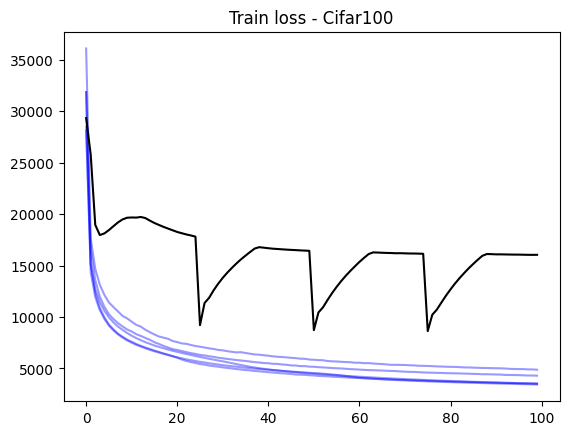

In [71]:
for model in old_models:
    plt.plot(model.train_loss, color='red', alpha=0.4)
for model in new_models:
    plt.plot(model.train_loss, color='blue', alpha=0.4)

plt.plot(model_old.train_loss, color='black')
    
plt.title('Train loss - Cifar100')

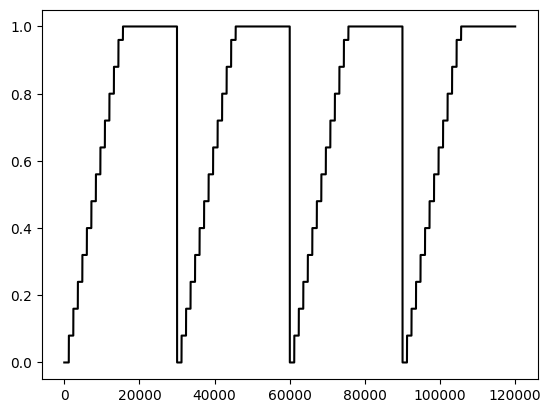

In [75]:
plt.plot(cycle_betas, color='black')

Text(0.5, 1.0, 'Test loss - Cifar100')

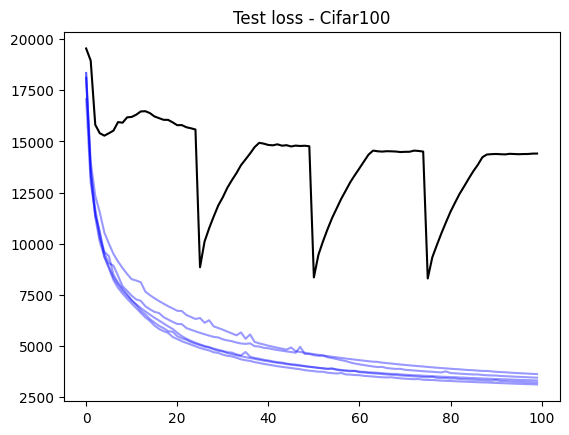

In [72]:
for model in old_models:
    plt.plot(model.test_loss, color='red', alpha=0.4)
for model in new_models:
    plt.plot(model.test_loss, color='blue', alpha=0.4)

plt.plot(model_old.test_loss, color='black')
    
# plt.legend([model.beta for model in old_models] + [model.beta for model in new_models])
plt.title('Test loss - Cifar100')

In [43]:
[(model.test_loss[-1], model.beta) for model in old_models]

[(3745.9508828922194, 1e-05),
 (3452.5522710060586, 5e-05),
 (3505.7646035953444, 0.0001),
 (3446.052903778699, 0.0005),
 (3426.479756257972, 0.001),
 (3765.7698202327806, 0.005),
 (4237.518998126594, 0.01),
 (5736.83203125, 0.05),
 (7133.230717873087, 0.1)]

In [42]:
[(model.test_loss[-1], model.beta) for model in new_models]

[(3109.5298200334823, 0.1),
 (3202.853271484375, 0.01),
 (3441.777159398916, 0.001),
 (3617.8612832828444, 0.0001)]

In [40]:
l

[(3109.5298200334823, 0.1),
 (3202.853271484375, 0.01),
 (3441.777159398916, 0.001),
 (3617.8612832828444, 0.0001)]

### Train loss

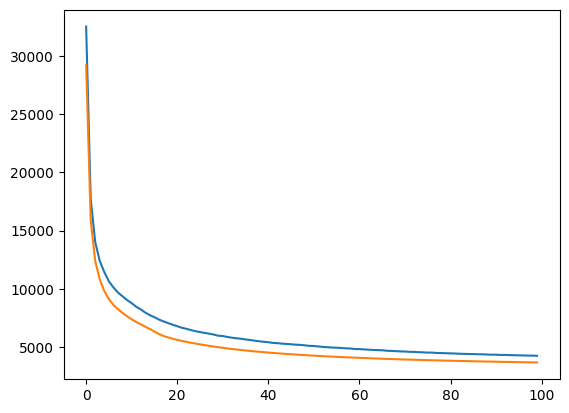

In [10]:
plt.plot(model.train_loss)
plt.plot(model_old.train_loss)

Text(0.5, 1.0, 'Train loss - Cifar100')

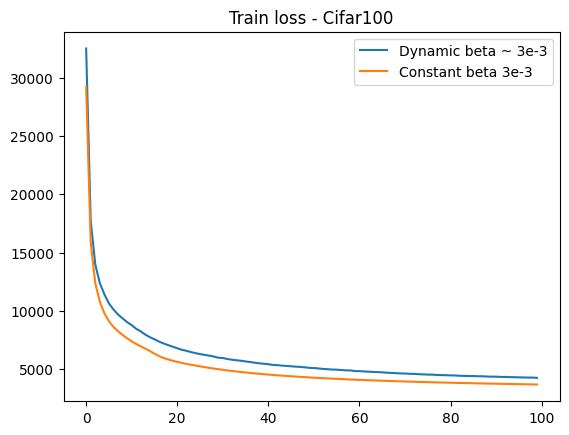

In [19]:
plt.plot(model.train_loss)
plt.plot(model_old.train_loss)
plt.legend(['Dynamic beta ~ 3e-3','Constant beta 3e-3'])
plt.title('Train loss - Cifar100')

Text(0.5, 1.0, 'Test loss - Cifar100')

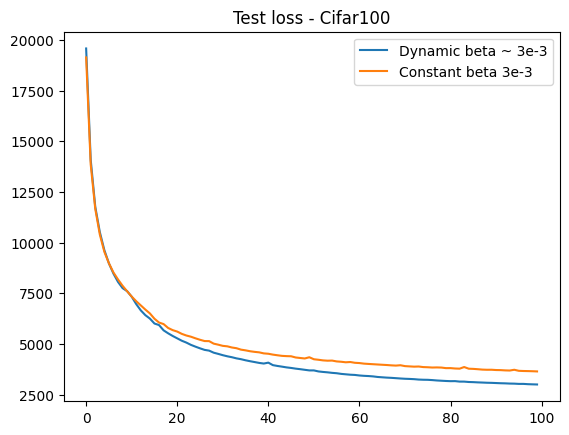

In [18]:
plt.plot(model.test_loss)
plt.plot(model_old.test_loss)
plt.legend(['Dynamic beta ~ 3e-3','Constant beta 3e-3'])
plt.title('Test loss - Cifar100')

In [23]:
np.array(kld_from_base_dist_list)

array([0.        , 0.05890235, 0.18990247, ..., 0.        , 0.        ,
       0.        ])

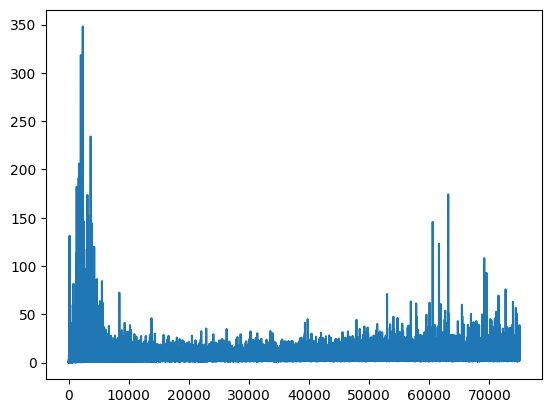

In [44]:
plt.plot(np.array(kld_from_base_dist_list)[np.array(kld_from_base_dist_list).nonzero()])

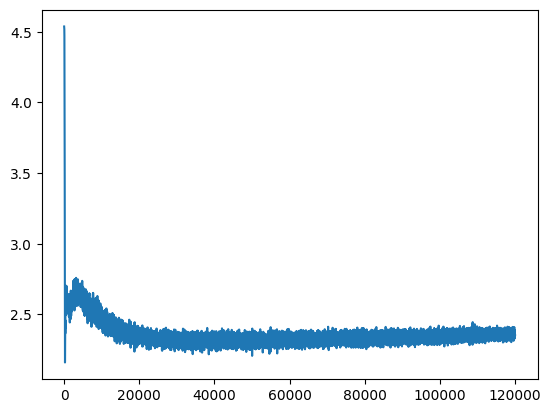

In [41]:
plt.plot(np.array(kld_from_std_normal_list))

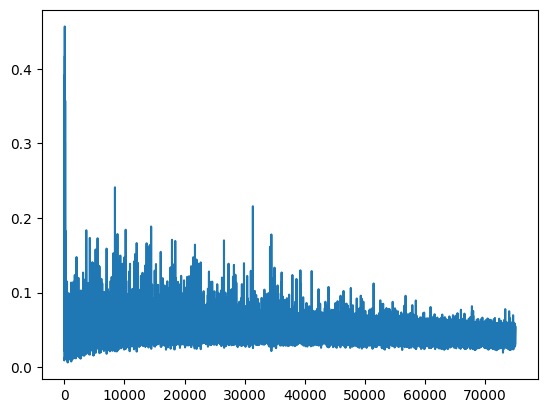

In [38]:
plt.plot(np.array(ratio_list)[np.array(ratio_list).nonzero()])
# np.array(ratio_list).mean() * 0.1

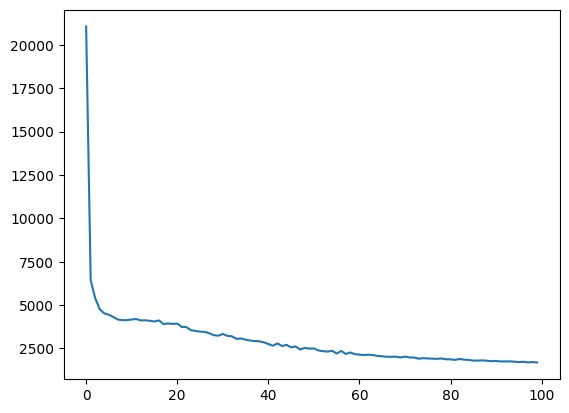

In [10]:
plt.plot(model.train_loss)

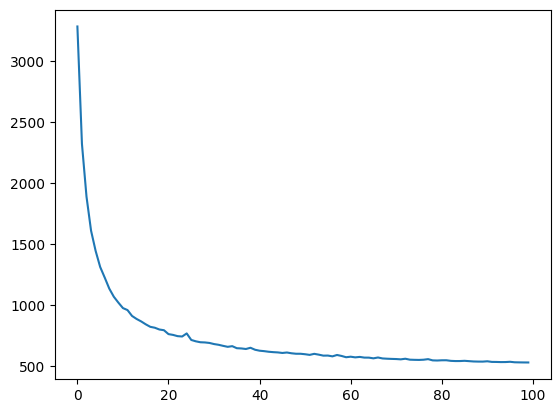

In [11]:
plt.plot(model.test_loss)

In [12]:
model.test_loss[-1]

527.4618467992666

In [320]:
# kl_divergence_gaussian(torch.tensor([[0,0]], dtype=torch.float), torch.tensor([[1,1]], dtype=torch.float), torch.tensor([[0,0]], dtype=torch.float), torch.tensor([[2,1]], dtype=torch.float))

mu1 = torch.tensor([[1]], dtype=torch.float)
std1 = torch.tensor([[2]], dtype=torch.float)
mu2 = torch.tensor([[1]], dtype=torch.float)
std2 = torch.tensor([[1]], dtype=torch.float)


mu3 = torch.tensor([[1], [1]], dtype=torch.float)
std3 = torch.tensor([[2], [2]], dtype=torch.float)
mu4 = torch.tensor([[1], [1]], dtype=torch.float)
std4 = torch.tensor([[1], [1]], dtype=torch.float)

# kl_divergence_gaussian(mu1, std1, mu2, std2)


In [321]:
n1 = Normal(mu1, std1)
n2 = Normal(mu2, std2)
n3 = Normal(mu3, std3)
n4 = Normal(mu4, std4)

torch.distributions.kl_divergence(n1, n2)
torch.distributions.kl_divergence(n3, n4)

# n.log_prob(torch.tensor([0,0], dtype=torch.float))

tensor([[0.8069]])

tensor([[0.8069],
        [0.8069]])

In [202]:
n.log_prob(z).mean(axis=-1).shape

torch.Size([200])

In [199]:
n.log_prob(z).shape

torch.Size([200, 256])

In [196]:
torch.any(n.log_prob(z) >= 1) #.exp()

tensor(False)

In [175]:
n = Normal(torch.tensor([0,1]), torch.tensor([1, 1]))
p = n.log_prob(torch.tensor([[-1,2],[0,0]], dtype=torch.float))

In [176]:
p.exp()

tensor([[0.2420, 0.2420],
        [0.3989, 0.2420]])

In [106]:
term3 = (mu2 - mu1) @ sigma2_inverse @ (mu2 - mu1)

torch.matmul((mu2 - mu1).T, sigma2_inverse)

torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse)  # 200, 1, 256


torch.bmm(torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse), mu1-mu2)


torch.matmul(torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse), mu2 - mu1)

torch.matmul(mu2 - mu1, torch.matmul((mu2 - mu1).unsqueeze(1), sigma2_inverse))


v = torch.tensor([2,3,4], dtype=torch.float)

V = v.diag()

V.trace()
V.det()

V @ torch.ones_like(v)


V.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)


tensor(9.)

tensor(24.)

tensor([2., 3., 4.])

tensor(9.)

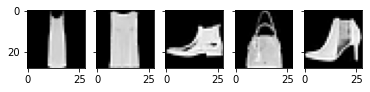

<Figure size 1296x432 with 0 Axes>

In [83]:
display(images[0:5], 5)

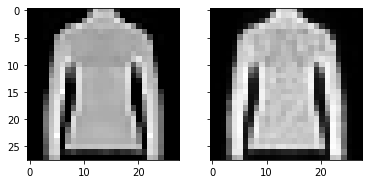

<Figure size 1296x432 with 0 Axes>

In [108]:
I = 23
x = images[I]
(_, _), x_hat = model(x.cuda())
x_hat = x_hat.view(-1, 28*28)
display([x, x_hat], 2)

In [192]:
latent_list = []
label_list = []
label_text_list = []
model.eval()
for idx, (image_batch, label_batch) in enumerate(train_loader):
    with torch.no_grad():
        (mu, _), _ = model(image_batch.to(device))
        latent_list += [mu1.unsqueeze(0).cpu() for mu1 in mu]
    label_list += [int(label) for label in label_batch]
    label_text_list += [fmnist_classes[int(label)] for label in label_batch]
    if idx > 100:
        break
latent_array = np.array([tensor.cpu().numpy()[0] for tensor in latent_list])

In [193]:
reducer = umap.UMAP()
scaler = StandardScaler().partial_fit(latent_array)
scaled_data = scaler.transform(latent_array)
embedding = reducer.fit_transform(scaled_data)

Text(0.5, 1.0, 'Casted latent instances')

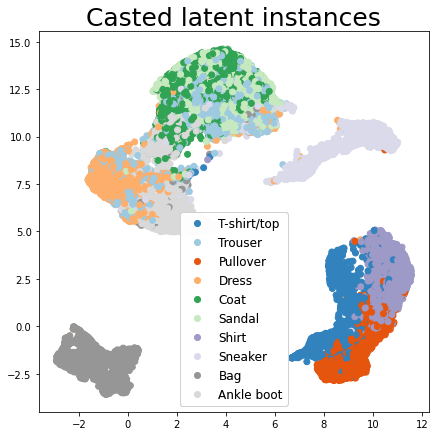

In [200]:
labels = pd.Series(label_text_list)
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
c = [[c for c in range(1,11)][x] for x in labels\
       .map({label: i for i, label in enumerate(labels.unique())})]

scatter = axes.scatter(
                    embedding[:, 0],
                    embedding[:, 1],
                    c=c,
                    cmap='tab20c')

# TODO: fix legend real class correlation
legend1 = axes.legend(scatter.legend_elements()[0],\
                    [text for text in fmnist_classes],\
                    fontsize=18, prop={'size': 12})

axes.add_artist(legend1)
fig.canvas.draw()
axes.set_title('Casted latent instances', fontsize=25)
# plt.savefig('test.png')

### Generate some instaces

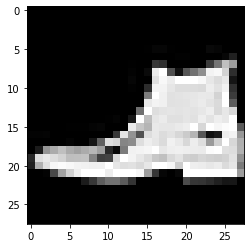

<Figure size 1296x432 with 0 Axes>

In [213]:
display(images[2], 1)

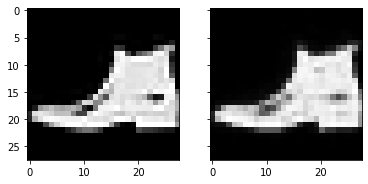

<Figure size 1296x432 with 0 Axes>

In [256]:
# i = np.random.randint(0,199)
i = 2
(mu, sigma), _ = model(images[i].to(device))
z1 = torch.normal(mu, sigma).to(device)
sample = model.decoder(z1)
display([images[i], sample], 2)

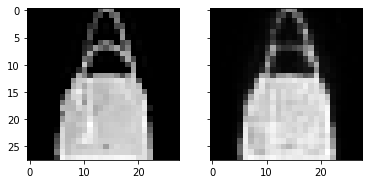

<Figure size 1296x432 with 0 Axes>

In [257]:
# i = np.random.randint(0,199)
i = 3
(mu, sigma), _ = model(images[i].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder(z2)
display([images[i], sample], 2)

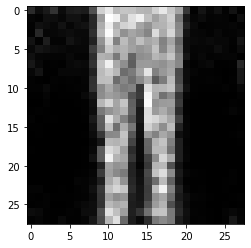

<Figure size 1296x432 with 0 Axes>

In [266]:
inv_transformed_points = reducer.inverse_transform([[-1,-2]])
sample = model.decoder(torch.tensor(inv_transformed_points).to(device))
display([sample], 1)

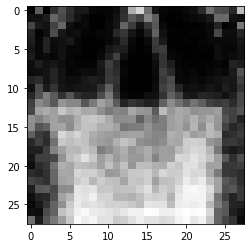

<Figure size 1296x432 with 0 Axes>

In [268]:
inv_transformed_points = reducer.inverse_transform([[7,8]])
sample = model.decoder(torch.tensor(inv_transformed_points).to(device))
display([sample], 1)

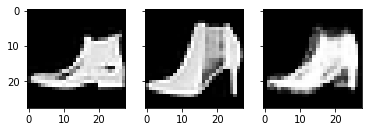

<Figure size 1296x432 with 0 Axes>

In [277]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+z2))
display([images[i1], images[i2], sample], 3)

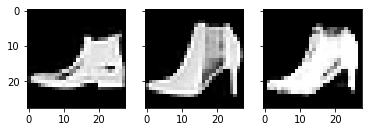

<Figure size 1296x432 with 0 Axes>

In [278]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+2*z2))
display([images[i1], images[i2], sample], 3)

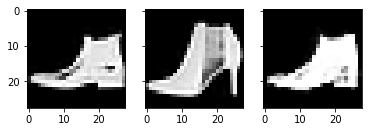

<Figure size 1296x432 with 0 Axes>

In [279]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((2*z1+z2))
display([images[i1], images[i2], sample], 3)

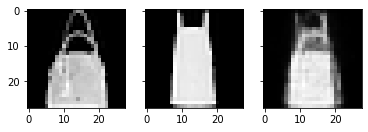

<Figure size 1296x432 with 0 Axes>

In [282]:
i1=3
i2=6
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+z2)/2)
display([images[i1], images[i2], sample], 3)

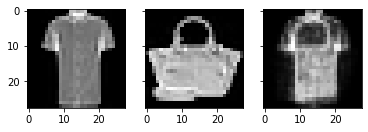

<Figure size 1296x432 with 0 Axes>

In [321]:
i1=10
i2=35
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((2*z1+z2)/2)
display([images[i1], images[i2], sample], 3)